# Getting started with PlanOut

### Your first experiment

This imports basic operators for doing random assignment and SimpleExperiment, the base class for logging

In [1]:
from planout.ops.random import *
from planout.experiment import SimpleExperiment
import pandas as pd

You can define new experiments by subclassing `SimpleExperiment`, and implementing an `assign()` method.

In [2]:
class SignupExperiment(SimpleExperiment):
  def assign(self, params, cookieid):
    params.button_color = UniformChoice(
      choices=["#ff0000", "#00ff00"],
      unit=cookieid)
    params.button_text = UniformChoice(
      choices=["Join now", "Sign me up!"],
      unit=cookieid) 

You can get randomized assignments for your input units by creating instances of the class. The code below gets the parameter values, `button_text` and `button_color` for `cookeid` = 4.

In [3]:
e = SignupExperiment(cookieid=4)
print(e.get('button_text'))
print(e.get('button_color'))

Sign me up!
#ff0000


Here are the assignments for 10 userids.

In [5]:
for i in range(10):
    e = SignupExperiment(cookieid=i)
    print("cookie = %s: %s, %s" % (i, e.get('button_text'), e.get('button_color')))

cookie = 0: Sign me up!, #00ff00
cookie = 1: Join now, #00ff00
cookie = 2: Sign me up!, #ff0000
cookie = 3: Sign me up!, #00ff00
cookie = 4: Sign me up!, #ff0000
cookie = 5: Join now, #00ff00
cookie = 6: Join now, #ff0000
cookie = 7: Join now, #00ff00
cookie = 8: Join now, #ff0000
cookie = 9: Join now, #ff0000


To check to see that the experiment is doing what we expect it to, we can simulate assignments for many userids and construct a dataframe with all of the assignments:

In [6]:
sim_users = [SignupExperiment(cookieid=i).get_params() for i in range(1000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments[:5])

  button_color  button_text
0      #00ff00  Sign me up!
1      #00ff00     Join now
2      #ff0000  Sign me up!
3      #00ff00  Sign me up!
4      #ff0000  Sign me up!


In [7]:
print(assignments.groupby(['button_text', 'button_color']).size())

button_text  button_color
Join now     #00ff00         234
             #ff0000         247
Sign me up!  #00ff00         246
             #ff0000         273
dtype: int64


### Unequal probability assignment with `WeightedChoice`

The `WeightedChoice` operator lets you choose among multiple choices with different frequencies. The `weights` parameter is any set of weights (integer or floating point) to select among `choices`.

In [8]:
class SignupExperiment2(SimpleExperiment):
  def assign(self, params, cookieid):
    params.button_color = UniformChoice(
      choices=["#ff0000", "#00ff00"],
      unit=cookieid)
    params.button_text = WeightedChoice(
      choices=["Join now!", "Sign me up!"],
      weights=[8, 2],
      unit=cookieid)

The button text frequencies reflect these weights, while the button color continues to be split in equal proportions.

In [9]:
sim_users = [SignupExperiment2(cookieid=i).get_params() for i in range(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['button_text', 'button_color']).size())

button_text  button_color
Join now!    #00ff00         844
             #ff0000         758
Sign me up!  #00ff00         182
             #ff0000         216
dtype: int64


### 41 shades of blue with `RandomInteger`

Google is infamous for testing [41 different shades of blue](http://www.nytimes.com/2009/03/01/business/01marissa.html) for their link colors. Let's implement that experiment.

In [10]:
class ColorExperiment(SimpleExperiment):
  def assign(self, params, userid):
    params.blue_value = RandomInteger(min=215, max=255, unit=userid)
    params.button_color = '#0000%s' % format(params.blue_value, '02x')
    params.button_text = 'Join now!'

In [11]:
ColorExperiment(userid=10).get_params()

{'blue_value': 247, 'button_color': '#0000f7', 'button_text': 'Join now!'}

In [13]:
sim_users = [ColorExperiment(userid=i).get_params() for i in range(20000)]
assignments = pd.DataFrame.from_dict(sim_users)

In [14]:
assignments[:5]

,blue_value,button_color,button_text
0,231,#0000e7,Join now!
1,248,#0000f8,Join now!
2,242,#0000f2,Join now!
3,230,#0000e6,Join now!
4,239,#0000ef,Join now!


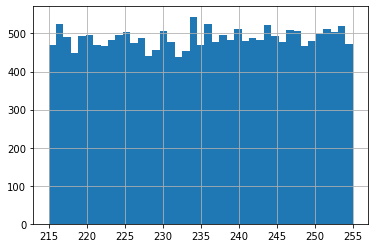

In [15]:
assignments['blue_value'].hist(bins=41);

### Using multiple input units to implement within-subjects designs

In some cases you might want to assign user-item pairs or user-session pairs to parameters. You can do this by simply passing more units into `assign()` and applying multiple units.

In [16]:
class SearchRankingExperiment(SimpleExperiment):
  def assign(self, params, userid, sessionid):
    params.ranking_model = UniformChoice(choices=['v0','v212'], unit=[userid, sessionid])

print(SearchRankingExperiment(userid=8, sessionid=1).get('ranking_model'))
print(SearchRankingExperiment(userid=8, sessionid=3).get('ranking_model'))

v212
v0


### Chaining together random assignments

Let's consider a case where you had multiple ranking models you wanted to compare against the control, and you were interested in doing a within-subjects design. You could first assign users to candidate models, and then assign users to either see the control or candidate model.

In [17]:
class SearchRankingExperiment(SimpleExperiment):
  def assign(self, params, userid, sessionid):
    params.candidate_model = UniformChoice(choices=['v212', 'v213', 'v214'], unit=userid)
    params.ranking_model = UniformChoice(choices=['v0', params.candidate_model], unit=[userid, sessionid])

for s in range(5):
    print(SearchRankingExperiment(userid=3, sessionid=s).get('ranking_model'))

v214
v0
v214
v0
v214


# How random assignment works in PlanOut

PlanOut hashes input data to provide developers with randomized parameter assignments. Unless otherwise specified, all random assignments are independent. It combines experiment-level and parameter-level salts with the given input units in a way that ensures that:
  * The same units (e.g., user ids) get mapped to different values for different experiments or parameters.
  * Assignments are as good as random.

Underneath the hood, PlanOut computes a hash that looks like

    f(SHA1(experiment_name.parameter_name.unit_id))

So for example, in the experiment below, PlanOut computes something that looks like:

    SHA1(RandomExample1.x.4) % 2
  
to select the value for `x` when the given `userid` is 4.

### Parameter-level salts

In [18]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)
    
sim_users = [RandomExample1(userid=i).get_params() for i in range(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

x  y
0  a    531
   b    475
1  a    478
   b    516
dtype: int64


PlanOut automatically "salts" each random assignment operator with the name of the parameter you are assigning. By writing `params.foo = Bar(...)`, you are implicitly passing the salt, "foo", into `Bar()`. The following experiment is equivalent to the code above.

In [22]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='y')
    
sim_users = [RandomExample1(userid=i).get_params() for i in range(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

x  y
0  a    510
   b    451
1  a    499
   b    540
dtype: int64


Comparing the cross tabs from the first and second experiments, it's clear that the two experiments produce identical assignments.

#### Changing the salts change the assignments:

In [23]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x2')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='y2')
    
sim_users = [RandomExample1(userid=i).get_params() for i in range(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

x  y
0  a    507
   b    493
1  a    506
   b    494
dtype: int64


#### Parameters with the same salt will have correlated assignments. If you use the same salt for the exact same kind of random operation, your assignments will be perfectly correlated.

In [31]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid, salt='x')
    params.y = UniformChoice(choices=['a','b'], unit=userid, salt='x')
    
sim_users = [RandomExample1(userid=i).get_params() for i in range(2000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

x  y
0  a    1006
1  b     994
dtype: int64


### Experiment-level salts

Each experiment also has its own salt. This makes it so that parameters with the same name will have independent random assignments, and also allows you to synchronize assignments across experiments in special situations.

#### By default, experiment class names are used as experiment-level salts

This keeps parameter assignments for parameters with the same name independent of one another.

In [27]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)
    
class RandomExample2(SimpleExperiment):
  def assign(self, params, userid):
    params.x = UniformChoice(choices=[4, 8], unit=userid)
    params.y = UniformChoice(choices=['m','n'], unit=userid)

sim_users = [RandomExample1(userid=i).get_params() for i in range(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

sim_users = [RandomExample2(userid=i).get_params() for i in range(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).size())

x  y
0  a    1009
   b     962
1  a    1004
   b    1025
dtype: int64
x  y
4  m    1017
   n     979
8  m    1026
   n     978
dtype: int64


#### Experiment-level salts can be specified by setting `self.salt`

The `self.salt` attribute of an experiment object specifies the experiment-level salt. You can set this attribute in the `setup()` method, which gets called before any assignments take place.

In [28]:
class RandomExample1(SimpleExperiment):
  def setup(self):
        self.salt = 'RandomExample2'

  def assign(self, params, userid):
    params.x = UniformChoice(choices=[0, 1], unit=userid)
    params.y = UniformChoice(choices=['a','b'], unit=userid)

sim_users = [RandomExample2(userid=i).get_params() for i in range(4000)]
assignments = pd.DataFrame.from_dict(sim_users)
print(assignments.groupby(['x', 'y']).agg(len))


x  y
4  m    1017
   n     979
8  m    1026
   n     978
dtype: int64


### Additional notes on random assignment

#### Random assignment with multiple units

When multiple units are used (e.g., in the case when user-item pairs are assigned to parameters in a within-subjects design), units are concatinated, so that if the input units are `userid=4` and `url='http://news.ycombinator.com'`, the hash operation would look like:

    f(SHA1('RandomExperiment1.show_thumbnail.6.http://news.ycombinator.com'))

In [29]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid, url):
    params.show_thumbnail = BernoulliTrial(p=0.15, unit=[userid, url])

RandomExample1(userid=6, url='http://news.ycombinator.com').get('show_thumbnail')

0

Note that since the names of units are not used, assignment does depend on the order of the units:

In [30]:
class RandomExample1(SimpleExperiment):
  def assign(self, params, userid, url):
    params.show_thumbnail = BernoulliTrial(p=0.15, unit=[url, userid])

RandomExample1(userid=6, url='http://news.ycombinator.com').get('show_thumbnail')

1

#### Namespaces

When an experiment is running under a namespace, the namespace name is concatenated with the experiment-level salt. See the namespace tutorial for more details.